In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('preprocessed_water_quality.csv')

## Model Training


Clustering Metrics:
Silhouette Score: 0.267
Calinski-Harabasz Index: 6618.092
Davies-Bouldin Index: 1.374

Number of clusters: 5

Cluster distribution:
0     6419
1    13585
2     5251
3     1521
4     1726
Name: count, dtype: int64


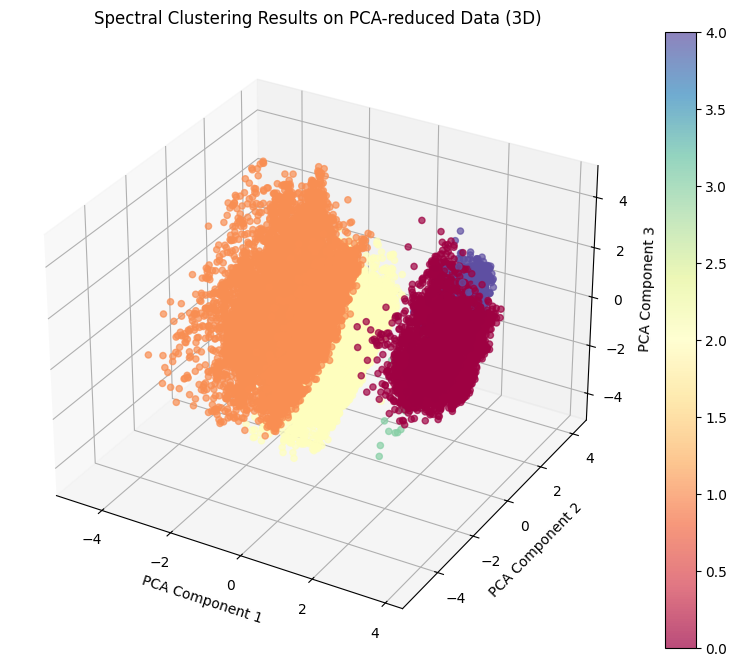


Cluster Characteristics:

Cluster 0:
0    2.699589
1   -0.377524
2    0.214743
3    0.491465
4   -0.229398
5    0.077380
6   -0.078627
7   -0.093808
8   -0.485480
dtype: float64

Cluster 1:
0   -1.398534
1   -0.592494
2    0.655260
3   -0.046015
4    0.043821
5   -0.108311
6    0.069193
7   -0.031971
8    0.165940
dtype: float64

Cluster 2:
0   -1.006948
1    1.176593
2   -1.987459
3    0.080612
4   -0.066374
5    0.162919
6    0.156634
7    0.042160
8   -0.171033
dtype: float64

Cluster 3:
0    2.172008
1    0.456504
2   -0.723979
3   -1.180840
4    0.573247
5   -0.172209
6   -0.758462
7    0.331108
8    0.562977
dtype: float64

Cluster 4:
0    2.117196
1    2.085589
2    0.728380
3   -0.670237
4    0.204996
5    0.220825
6   -0.060341
7    0.180467
8    0.523643
dtype: float64


In [63]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert all column names to strings (if necessary)
df.columns = df.columns.astype(str)

# Apply PCA to reduce data to 3D for visualization
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# Create Spectral Clustering model
n_clusters = 5  # You can adjust this
spectral = SpectralClustering(n_clusters=n_clusters,
                             affinity='nearest_neighbors',
                             random_state=42)

# Fit and predict clusters
clusters = spectral.fit_predict(df)

# Add cluster labels to the dataframe
df['Cluster'] = clusters

# Calculate clustering evaluation metrics
silhouette = silhouette_score(df, clusters)
calinski = calinski_harabasz_score(df, clusters)
davies = davies_bouldin_score(df, clusters)

print("\nClustering Metrics:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Index: {calinski:.3f}")
print(f"Davies-Bouldin Index: {davies:.3f}")

# Print basic clustering information
print(f"\nNumber of clusters: {n_clusters}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# 3D Visualization of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of PCA-reduced data
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], 
                      c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('Spectral Clustering Results on PCA-reduced Data (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# Print cluster characteristics
print("\nCluster Characteristics:")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.mean().drop('Cluster'))


Clustering Metrics:
Silhouette Score: 0.211
Calinski-Harabasz Index: 8605.083
Davies-Bouldin Index: 1.693

Number of clusters: 5

Cluster distribution:
0    5412
1    7348
2    6084
3    3239
4    6419
Name: count, dtype: int64


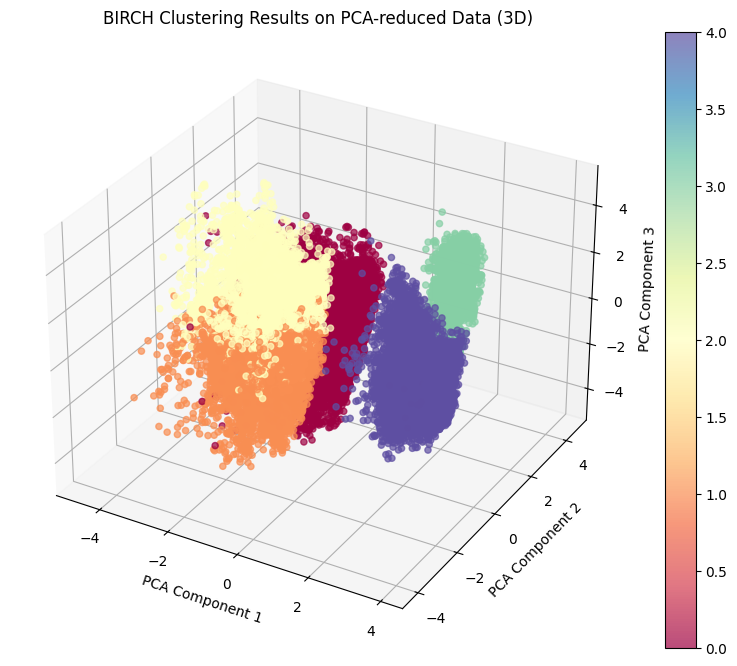


Cluster Characteristics:

Cluster 0:
0   -1.033729
1    1.116871
2   -1.938561
3    0.066578
4   -0.069432
5    0.267063
6    0.108578
7   -0.020403
8   -0.142209
dtype: float64

Cluster 1:
0   -1.237133
1   -1.412673
2    0.046106
3   -0.259089
4    0.065665
5   -0.161001
6   -0.061071
7    0.010870
8    0.218768
dtype: float64

Cluster 2:
0   -1.575902
1    0.403709
2    1.412938
3    0.218131
4    0.023600
5   -0.143317
6    0.266920
7   -0.027748
8    0.086494
dtype: float64

Cluster 3:
0    2.143909
1    1.328491
2    0.054940
3   -0.907180
4    0.377334
5    0.034864
6   -0.388423
7    0.247460
8    0.540969
dtype: float64

Cluster 4:
0    2.699589
1   -0.377524
2    0.214743
3    0.491465
4   -0.229398
5    0.077380
6   -0.078627
7   -0.093808
8   -0.485480
dtype: float64


In [64]:
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd

# Apply PCA to reduce data to 3D for visualization
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df)

# Create BIRCH clustering model
birch = Birch(n_clusters=5)  # Adjust clusters as needed

# Fit and predict clusters
clusters = birch.fit_predict(df)

# Add cluster labels to the DataFrame
df['Cluster'] = clusters

# Calculate clustering evaluation metrics
silhouette = silhouette_score(df, clusters)
calinski = calinski_harabasz_score(df, clusters)
davies = davies_bouldin_score(df, clusters)

print("\nClustering Metrics:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Index: {calinski:.3f}")
print(f"Davies-Bouldin Index: {davies:.3f}")

# Print basic clustering information
print(f"\nNumber of clusters: {len(set(clusters))}")
print("\nCluster distribution:")
print(pd.Series(clusters).value_counts().sort_index())

# 3D Visualization of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of PCA-reduced data
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], 
                      c=clusters, cmap='Spectral', alpha=0.7)

ax.set_title('BIRCH Clustering Results on PCA-reduced Data (3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)
plt.show()

# Print cluster characteristics
print("\nCluster Characteristics:")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.mean().drop('Cluster'))

In [65]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.cluster import Birch
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# from sklearn.utils import resample

# # Number of bootstrap iterations
# n_bootstraps = 10  

# # Number of clusters for BIRCH
# n_clusters = 5  

# # Store clustering metrics across bootstraps
# silhouette_scores = []
# calinski_scores = []
# davies_scores = []
# cluster_results = []

# for i in range(n_bootstraps):
#     print(f"Bootstrap Iteration {i+1}/{n_bootstraps}...")

#     # Bootstrap resampling
#     df_sample = resample(df, replace=True, n_samples=len(df))

#     # Create and fit BIRCH model
#     birch = Birch(n_clusters=n_clusters)
#     clusters = birch.fit_predict(df_sample)

#     # Store cluster results
#     cluster_results.append(clusters)

#     # Compute clustering metrics
#     silhouette = silhouette_score(df_sample, clusters)
#     calinski = calinski_harabasz_score(df_sample, clusters)
#     davies = davies_bouldin_score(df_sample, clusters)

#     silhouette_scores.append(silhouette)
#     calinski_scores.append(calinski)
#     davies_scores.append(davies)

# # Compute mean and std for clustering metrics
# print("\nBootstrap Aggregated Metrics:")
# print(f"Silhouette Score: {np.mean(silhouette_scores):.3f} ± {np.std(silhouette_scores):.3f}")
# print(f"Calinski-Harabasz Index: {np.mean(calinski_scores):.3f} ± {np.std(calinski_scores):.3f}")
# print(f"Davies-Bouldin Index: {np.mean(davies_scores):.3f} ± {np.std(davies_scores):.3f}")

# # Visualize clusters from the last bootstrap iteration (for interpretation)
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=cluster_results[-1], cmap='Spectral', alpha=0.6)
# plt.colorbar(scatter)
# plt.title('BIRCH Clustering Results (Last Bootstrap Sample)')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()